In [1]:
!pip install 'aif360[LFR]'

     |████████████████████████████████| 175 kB 7.7 MB/s 
     |████████████████████████████████| 564 kB 42.3 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=ad9a3bfdb1234aa92b34c82feea7d4825199ee3493110919ca9ebdc8bbd47a9a
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [2]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/german

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/german


In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc

--2022-05-13 10:56:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german.data’

german.data         100%[===================>]  77.92K  --.-KB/s    in 0.03s   

2022-05-13 10:56:41 (2.98 MB/s) - ‘german.data’ saved [79793/79793]

--2022-05-13 10:56:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4679 (4.6K) [application/x-httpd-php]
Saving to: ‘german.doc’

german.doc          100%[===================>]   4.57K  --.-KB/s    in 0s 

In [4]:
!pip install aequitas==0.42.0
!pip install fairlearn==0.4.6

     |████████████████████████████████| 2.2 MB 10.1 MB/s 
     |████████████████████████████████| 97 kB 6.6 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
     |████████████████████████████████| 596 kB 36.3 MB/s 
     |████████████████████████████████| 727 kB 40.1 MB/s 
     |████████████████████████████████| 161 kB 38.1 MB/s 
     |████████████████████████████████| 83 kB 1.3 MB/s 
     |████████████████████████████████| 456 kB 45.2 MB/s 
     |████████████████████████████████| 80 kB 7.4 MB/s 
     |████████████████████████████████| 2.7 MB 35.0 MB/s 
  Created wheel for Flask-Bootstrap: filename=Flask_Bootstrap-3.3.7.1-py3-none-any.whl size=460123 sha256=29db1d09457a028e47b8b6f19d3d4c943d5b65f21d42cd68b9f5372f5c8ceb79
  Stored in directory: /root/.cache/pip/wheels/67/a2/d6/50d039c9b59b4caca6d7b53839c8100354a52ab7553d2456eb
  Created wheel for markdown2: filename=markdown2-2.3.5-py3-none-any.whl size=33327 sha256=a221739d475b3b99a69393684ebd0b7114efff54ad1826c0a2100974a17

**Importing all libraries**

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
from google.colab import files

from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import KFold, cross_val_score
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler  #MinMaxScaler
import numpy as np
from sklearn.linear_model import LogisticRegression
from aif360.algorithms.inprocessing import AdversarialDebiasing

In [6]:
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

Setting the fairness Matrixs

In [7]:
races = ['Young','Old']

privileged_groups = [{'age': 0}]
unprivileged_groups = [{'age': 1}]
dataset_orig = load_preproc_data_german(['age'])

Managing the dataset into train and test

In [8]:

train, test = dataset_orig.split([0.7], shuffle=True)
print("training data size", train.features.shape)
print("dataset feature names", train.feature_names)

#Normalize the dataset, both train and test. This should always be done in any machine learning pipeline!
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(train.features)
y_train = train.labels.ravel()

X_test = scale_orig.transform(test.features) 
y_test = test.labels.ravel()

training data size (700, 11)
dataset feature names ['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


Functions used in all the tasks

In [9]:
def find_score(predictions, labels):
    
    correct_ans = []
    
    for i in labels:
      correct_ans.append(i)
    
    lists = zip(predictions, correct_ans)
    
    preds = []
    corrects = []
    
    score = 0
    
    for i in lists:
        if int(round(i[0])) == int(round(i[1])):
            score = score + 1
        else:
            pass
        
        var = round(i[0])
        preds.append(int(var))
        corrects.append(i[1])
      
    
    accuracy = score/len(labels)
    print("Model Accuracy", accuracy)
    return accuracy

**Task 1 Finding an 5 Fold Cross validation for Accuracy and Fairness**

In [10]:
print(train.features.shape)
print()
trainVar, trainA = train.split([0.8], shuffle=True)

print(trainA.features.shape)

trainVar, trainB = trainVar.split([0.75], shuffle=True)

print(trainB.features.shape)

trainVar, trainC = trainVar.split([0.66666], shuffle=True)

print(trainC.features.shape)

trainD, trainE = trainVar.split([0.5], shuffle=True)

print(trainD.features.shape)
print(trainE.features.shape)

train_cross = [trainA, trainB, trainC, trainD, trainE]
X_train_cross = train_cross
Y_train_cross = [0] * 5

for i in range(len(train_cross)):
    Y_train_cross[i] = train_cross[i].labels.ravel()

scale_orig = StandardScaler()   #setup the scaler object

for i in range(len(train_cross)):
    X_train_cross[i] = scale_orig.fit_transform(train_cross[i].features) #scale both features and labels



(700, 11)

(140, 11)
(140, 11)
(141, 11)
(139, 11)
(140, 11)


In [11]:
from seaborn import matrix
Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
scores = []

solvers = ['newton-cg', 'lbfgs', 'liblinear']

datas = {}

with open('task1crossval2Results.csv', 'w') as csvfile:
    field_names = ['Activation', 'C' , 'crossVal1', 'crossVal2', 'crossVal3', 'crossVal4', 'crossVal5','Accuracy', 'general', 
                   'Par_diff1', 'Par_diff2', 'Par_diff3', 'Par_diff4', 'Par_diff5', 'par_diff_avg',
                   'ep_opp1', 'ep_opp2','ep_opp3', 'ep_opp4', 'ep_opp5', 'ep_opp_avg',
                   'avg_odd1', 'avg_odd2', 'avg_odd3', 'avg_odd4', 'avg_odd5','avg_odds_avg' ,'TPR', 'FPR'] #Name of the columns for the .csv file
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()


    for solv in solvers:
          for c in Cs:
              classifier = LogisticRegression(C=c, solver=solv)

              data = {}
              accuracies = []
              cs = []
              activations = []
              par_diff = []
              ep_opp = []
              avg_odds = []
              TPR = []
              FPR = []


              for i in range(len(train_cross)):

                  X_test_cross = []
                  Y_test_cross = []
                  indexs = []
                  ind = []
                  X = []
                  Y = []

                  for j in range(len(train_cross)):
                      if i == j:
                          X_test_cross = X_train_cross[j]
                          Y_test_cross = Y_train_cross[j]
                          ind.append(j)
                      else:
                          indexs.append(j)


                  X = np.concatenate([X_train_cross[indexs[0]], X_train_cross[indexs[1]], X_train_cross[indexs[2]]])
                  Y = np.concatenate([Y_train_cross[indexs[0]], Y_train_cross[indexs[1]], Y_train_cross[indexs[2]]])
                  X = np.concatenate([X, X_train_cross[indexs[3]]])
                  Y = np.concatenate([Y, Y_train_cross[indexs[3]]])

                  LR = classifier.fit(X, Y) #fit all the data that is not in the test

                  predictions = LR.predict(X_test_cross)
                  
                  acc = find_score(predictions, Y_test_cross)

                  train_copy = trainA


                  if i == 0:
                    train_copy = trainA

                  elif i == 1:
                    train_copy = trainB
                  
                  elif i == 2:
                    train_copy = trainC

                  elif i == 3:
                    train_copy = trainD
                  
                  elif i == 4:
                    train_copy = trainE

                  else:
                    print("Error")

                  test_pred = train_copy.copy()
                  predictions.resize((len(predictions),1))
                  test_pred.labels = predictions

                  metric = ClassificationMetric(train_copy, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
                  metric_arrs = {}
                  metric_arrs['C'] = c
                  metric_arrs['Activation'] = solv
                  metric_arrs['Accuracy'] = acc
                  metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
                  metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
                  metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
                  #metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
                  #metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
                  metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
                  metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

                  #print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, acc))
                  #print(metric_arrs)
                  #print('\n')


                  accuracies.append(acc)
                  cs.append(c)
                  activations.append(solv)
                  par_diff.append((metric.statistical_parity_difference()))
                  ep_opp.append((metric.equal_opportunity_difference()))
                  avg_odds.append((metric.average_odds_difference()))
                  TPR.append((metric.generalized_true_positive_rate()))
                  FPR.append((metric.num_generalized_false_positives()))


              print("Accuracies: ", accuracies)
              print("Cs", c)
              print("Activation: ", activations)
              print("Par_diff: ", par_diff)
              print("ep_opp: ", ep_opp)
              print("avg_odd: ", avg_odds)
              print("TPR: ", TPR)
              print("FPR: ", FPR)

              pred_test = LR.predict(X_test)
              test_acc = find_score(pred_test, y_test)
              print("Generalisability --- ", test_acc)

              acc = sum(accuracies)/len(accuracies)
              par_diff_avg = sum(par_diff)/len(par_diff)
              ep_opp_avg = sum(ep_opp)/len(ep_opp)
              avg_odds_avg = sum(avg_odds)/len(avg_odds)

              writer.writerow({'Activation': solv, 'C': c , 'crossVal1': accuracies[0], 'crossVal2': accuracies[1], 'crossVal3': accuracies[2], 'crossVal4': accuracies[3], 'crossVal5': accuracies[4],'Accuracy': acc, 'general': test_acc, 
                               'Par_diff1': par_diff[0], 'Par_diff2': par_diff[1], 'Par_diff3': par_diff[2], 'Par_diff4': par_diff[3], 'Par_diff5': par_diff[4], 'par_diff_avg': par_diff_avg,
                   'ep_opp1': ep_opp[0], 'ep_opp2': ep_opp[1],'ep_opp3': ep_opp[2], 'ep_opp4': ep_opp[3], 'ep_opp5': ep_opp[4], 'ep_opp_avg': ep_opp_avg,
                   'avg_odd1': avg_odds[0], 'avg_odd2': avg_odds[1], 'avg_odd3': avg_odds[2], 'avg_odd4': avg_odds[3], 'avg_odd5': avg_odds[4],'avg_odds_avg': avg_odds_avg , 'TPR': TPR[0], 'FPR': FPR[0]}) #save the data into .csv

          
files.download('task1crossval2Results.csv')


Model Accuracy 0.6928571428571428
Model Accuracy 0.65
Model Accuracy 0.6666666666666666
Model Accuracy 0.6618705035971223
Model Accuracy 0.6928571428571428
Accuracies:  [0.6928571428571428, 0.65, 0.6666666666666666, 0.6618705035971223, 0.6928571428571428]
Cs 1e-05
Activation:  ['newton-cg', 'newton-cg', 'newton-cg', 'newton-cg', 'newton-cg']
Par_diff:  [0.0, 0.0, 0.0, 0.0, 0.0]
ep_opp:  [0.0, 0.0, 0.0, 0.0, 0.0]
avg_odd:  [0.0, 0.0, 0.0, 0.0, 0.0]
TPR:  [1.0, 1.0, 1.0, 1.0, 1.0]
FPR:  [0.0, 0.0, 0.0, 0.0, 0.0]
Model Accuracy 0.7633333333333333
Generalisability ---  0.7633333333333333
Model Accuracy 0.6928571428571428
Model Accuracy 0.65
Model Accuracy 0.6666666666666666
Model Accuracy 0.6618705035971223
Model Accuracy 0.6928571428571428
Accuracies:  [0.6928571428571428, 0.65, 0.6666666666666666, 0.6618705035971223, 0.6928571428571428]
Cs 0.0001
Activation:  ['newton-cg', 'newton-cg', 'newton-cg', 'newton-cg', 'newton-cg']
Par_diff:  [0.0, 0.0, 0.0, 0.0, 0.0]
ep_opp:  [0.0, 0.0, 0.0, 0.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Plotting the Hyperparamters for TASK1** 

In [12]:
task1_df = pd.read_csv("task1crossval2Results.csv")
task1_df

,Activation,C,crossVal1,crossVal2,crossVal3,crossVal4,crossVal5,Accuracy,general,Par_diff1,...,ep_opp5,ep_opp_avg,avg_odd1,avg_odd2,avg_odd3,avg_odd4,avg_odd5,avg_odds_avg,TPR,FPR
0,newton-cg,0.00001,0.692857,0.650000,0.666667,0.661871,0.692857,0.672850,0.763333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
1,newton-cg,0.00010,0.692857,0.650000,0.666667,0.661871,0.692857,0.672850,0.763333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
2,newton-cg,0.00100,0.692857,0.650000,0.666667,0.661871,0.692857,0.672850,0.763333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
3,newton-cg,0.01000,0.685714,0.657143,0.666667,0.661871,0.700000,0.674279,0.770000,0.290323,...,0.333333,0.153030,0.306818,0.215909,0.000000,0.000000,0.358974,0.176340,1.0,0.0
4,newton-cg,0.10000,0.678571,0.678571,0.659574,0.683453,0.714286,0.682891,0.746667,0.580645,...,0.583333,0.448990,0.613636,0.428030,0.425214,0.555556,0.676282,0.539744,1.0,0.0
5,newton-cg,1.00000,0.678571,0.678571,0.645390,0.683453,0.714286,0.680054,0.746667,0.580645,...,0.583333,0.507576,0.613636,0.602273,0.480769,0.555556,0.676282,0.585703,1.0,0.0
6,newton-cg,10.00000,0.678571,0.678571,0.659574,0.683453,0.714286,0.682891,0.746667,0.580645,...,0.583333,0.507576,0.613636,0.602273,0.557692,0.555556,0.676282,0.601088,1.0,0.0
7,newton-cg,100.00000,0.671429,0.671429,0.659574,0.683453,0.714286,0.680034,0.746667,0.612903,...,0.583333,0.499394,0.638636,0.473485,0.557692,0.555556,0.676282,0.580330,1.0,0.0
8,newton-cg,1000.00000,0.671429,0.671429,0.659574,0.683453,0.714286,0.680034,0.746667,0.612903,...,0.583333,0.499394,0.638636,0.473485,0.557692,0.555556,0.676282,0.580330,1.0,0.0
9,lbfgs,0.00001,0.692857,0.650000,0.666667,0.661871,0.692857,0.672850,0.763333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0


**Task 1 Most Fair Model**

Using the test data which was split from train before the cross validation.

In [28]:
def formula(acc, gen, equ, odds, diff):

    return (acc + gen)/ 1 - (equ + odds + diff) #The algirthm to select the model

df = task1_df

accuacy = df['Accuracy'] #get only the wanted information
general = df['general']
equility = df['ep_opp_avg']
avg_odds = df['avg_odds_avg']
par_diff = df['par_diff_avg']


C = df['C']             #get the paramters of the model
act = df['Activation']


answers = 0

for i in range(len(accuacy)):
    
    ans = formula(accuacy[i], general[i], equility[i], avg_odds[i], par_diff[i]) #loop through varibales and find answer
    
    if ans > answers:             #if it is th best the save the score and variables
        answers = ans
        bestC = C[i]
        bestActivation = act[i]
        
print(bestC, bestActivation, answers) #print the best

1e-05 newton-cg 1.4361836245289483


Model Accuracy 0.7466666666666667
C : 10 | Activation: lbfgs | Accuracy: 0.7466666666666667
{'stat_par_diff': 0.4130434782608695, 'eq_opp_diff': 0.36363636363636365, 'avg_odds_diff': 0.45104895104895104, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}




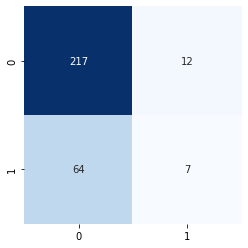

In [13]:

solv = 'lbfgs'
c = 10


learner = LogisticRegression(solver=solv, random_state=1, C=c)  
learner.fit(X_train,y_train)
predictions = learner.predict(X_test)


conclude = zip(predictions, y_test)

score = 0

correct_ans = []

for i in y_test:
  correct_ans.append(i)

lists = zip(predictions, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print("Model Accuracy", accuracy)

conf_mat = confusion_matrix(corrects, preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

test_pred = test.copy()
predictions.resize((len(predictions),1))
test_pred.labels = predictions

metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
#metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
#metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, accuracy))
print(metric_arrs)
print('\n')

**Task 1 Most Accurate Model**

0.7633333333333333
C : 1e-05 | Activation: lbfgs | Accuracy: 0.7633333333333333
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}




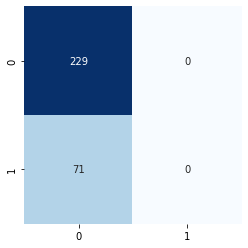

In [14]:


solv = 'lbfgs'
c = 0.00001

learner = LogisticRegression(solver=solv, random_state=1, C=c)  
learner.fit(X_train,y_train)
predictions = learner.predict(X_test)

conclude = zip(predictions, y_test)

score = 0

correct_ans = []

for i in y_test:
  correct_ans.append(i)

lists = zip(predictions, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print(accuracy)

conf_mat = confusion_matrix(corrects, preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

test_pred = test.copy()
predictions.resize((len(predictions),1))
test_pred.labels = predictions

metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
#metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
#metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, accuracy))
print(metric_arrs)
print('\n')

**Task 3 Select the model (5)**

0.7633333333333333
C : 1e-05 | Activation: newton-cg | Accuracy: 0.7633333333333333
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}




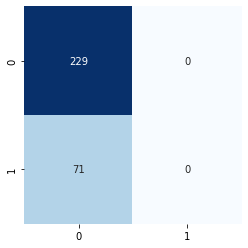

In [23]:
solv = 'newton-cg'
c = 0.00001

learner = LogisticRegression(solver=solv, random_state=1, C=c)  
learner.fit(X_train,y_train)
predictions = learner.predict(X_test)

conclude = zip(predictions, y_test)

score = 0

correct_ans = []

for i in y_test:
  correct_ans.append(i)

lists = zip(predictions, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print(accuracy)

conf_mat = confusion_matrix(corrects, preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

test_pred = test.copy()
predictions.resize((len(predictions),1))
test_pred.labels = predictions

metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
#metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
#metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, accuracy))
print(metric_arrs)
print('\n')

**Task 2 Reweighting and applying 5 Fold Cross Validation**

In [15]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

train_fair = RW.fit_transform(train)
trainA_fair = RW.fit_transform(trainA.copy())
trainB_fair = RW.fit_transform(trainB.copy())
trainC_fair = RW.fit_transform(trainC.copy())
trainD_fair = RW.fit_transform(trainD.copy())
trainE_fair = RW.fit_transform(trainE.copy())

train_weights = [trainA_fair.instance_weights, trainB_fair.instance_weights, trainC_fair.instance_weights, trainD_fair.instance_weights, trainE_fair.instance_weights]

print("subgroup weights", np.unique(trainA_fair.instance_weights), np.unique(trainB_fair.instance_weights), np.unique(trainC_fair.instance_weights), np.unique(trainD_fair.instance_weights), np.unique(trainE_fair.instance_weights))
train_cross_fair = [trainA_fair, trainB_fair, trainC_fair, trainD_fair, trainE_fair]

X_train_cross_fair = train_cross_fair
Y_train_cross_fair = [0] * 5

scale_orig = StandardScaler()   #setup the scaler object

for i in range(len(train_cross_fair)):
    Y_train_cross_fair[i] = train_cross_fair[i].labels.ravel()

for i in range(len(train_cross)):
    X_train_cross_fair[i] = scale_orig.fit_transform(train_cross_fair[i].features) #scale both features and labels

subgroup weights [0.86558442 0.98079777 1.04620536 1.07392857] [0.67083333 0.950625   1.10675676 1.35909091] [0.79487179 0.96491228 1.07843137 1.14814815] [0.63868905 0.91442635 1.22426197 1.40647482] [0.59065934 0.93739496 1.17738095 1.44345238]


In [16]:
Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
scores = []

solvers = ['newton-cg', 'lbfgs', 'liblinear']

with open('task2crossval2Results.csv', 'w') as csvfile:
    field_names = ['Activation', 'C' , 'crossVal1', 'crossVal2', 'crossVal3', 'crossVal4', 'crossVal5','Accuracy', 'general', 
                   'Par_diff1', 'Par_diff2', 'Par_diff3', 'Par_diff4', 'Par_diff5', 'par_diff_avg',
                   'ep_opp1', 'ep_opp2','ep_opp3', 'ep_opp4', 'ep_opp5', 'ep_opp_avg',
                   'avg_odd1', 'avg_odd2', 'avg_odd3', 'avg_odd4', 'avg_odd5','avg_odds_avg' ,'TPR', 'FPR'] #Name of the columns for the .csv file
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()



    for solv in solvers:

          for c in Cs:

              data = {}
              accuracies = []
              cs = []
              activations = []
              par_diff = []
              ep_opp = []
              avg_odds = []
              TPR = []
              FPR = []

              classifier = LogisticRegression(C=c, solver=solv)

              for i in range(len(train_cross)):

                  X_test_cross_fair = []
                  Y_test_cross_fair = []
                  indexs = []
                  ind = []
                  X = []
                  Y = []

                  for j in range(len(train_cross)):
                      if i == j:
                          X_test_cross_fair = X_train_cross_fair[j]
                          Y_test_cross_fair = Y_train_cross_fair[j]
                          ind.append(j)
                      else:
                          indexs.append(j)


                  X = np.concatenate([X_train_cross_fair[indexs[0]], X_train_cross_fair[indexs[1]], X_train_cross_fair[indexs[2]]])
                  Y = np.concatenate([Y_train_cross_fair[indexs[0]], Y_train_cross_fair[indexs[1]], Y_train_cross_fair[indexs[2]]])
                  X = np.concatenate([X, X_train_cross_fair[indexs[3]]])
                  Y = np.concatenate([Y, Y_train_cross_fair[indexs[3]]])
                  bias_weights = np.concatenate([train_weights[indexs[0]], train_weights[indexs[1]], train_weights[indexs[2]]])
                  bias_weights = np.concatenate([bias_weights, train_weights[indexs[3]]])


                  #LR = classifier.fit(X, Y, sample_weight=train_cross_fair_weight.instance_weights) #,sample_weight=train.instance_weights fit all the data that is not in the test

                  LR = classifier.fit(X, Y, sample_weight=bias_weights)



                  predictions = LR.predict(X_test_cross_fair)
                  
                  acc = find_score(predictions, Y_test_cross_fair)

                  #train_copy = trainA


                  if i == 0:
                    train_copy = trainA_fair

                  elif i == 1:
                    train_copy = trainB_fair
                  
                  elif i == 2:
                    train_copy = trainC_fair

                  elif i == 3:
                    train_copy = trainD_fair
                  
                  elif i == 4:
                    train_copy = trainE_fair

                  else:
                    print("Error")

                  test_pred = train_copy.copy()
                  predictions.resize((len(predictions),1))
                  test_pred.labels = predictions

                  metric = ClassificationMetric(train_copy, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
                  metric_arrs = {}
                  metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
                  metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
                  metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
                  #metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
                  #metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
                  metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
                  metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

                  print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, acc))
                  print(metric_arrs)
                  print('\n')


                  accuracies.append(acc)
                  cs.append(c)
                  activations.append(solv)
                  par_diff.append((metric.statistical_parity_difference()))
                  ep_opp.append((metric.equal_opportunity_difference()))
                  avg_odds.append((metric.average_odds_difference()))
                  TPR.append((metric.generalized_true_positive_rate()))
                  FPR.append((metric.num_generalized_false_positives()))


              print("Accuracies: ", accuracies)
              print("Cs", c)
              print("Activation: ", activations)
              print("Par_diff: ", par_diff)
              print("ep_opp: ", ep_opp)
              print("avg_odd: ", avg_odds)
              print("TPR: ", TPR)
              print("FPR: ", FPR)

              pred_test = LR.predict(X_test)
              test_acc = find_score(pred_test, y_test)
              print("Generalisability --- ", test_acc)

              acc = sum(accuracies)/len(accuracies)
              par_diff_avg = sum(par_diff)/len(par_diff)
              ep_opp_avg = sum(ep_opp)/len(ep_opp)
              avg_odds_avg = sum(avg_odds)/len(avg_odds)


              writer.writerow({'Activation': solv, 'C': c , 'crossVal1': accuracies[0], 'crossVal2': accuracies[1], 'crossVal3': accuracies[2], 'crossVal4': accuracies[3], 'crossVal5': accuracies[4],'Accuracy': acc, 'general': test_acc, 
                               'Par_diff1': par_diff[0], 'Par_diff2': par_diff[1], 'Par_diff3': par_diff[2], 'Par_diff4': par_diff[3], 'Par_diff5': par_diff[4], 'par_diff_avg': par_diff_avg,
                   'ep_opp1': ep_opp[0], 'ep_opp2': ep_opp[1],'ep_opp3': ep_opp[2], 'ep_opp4': ep_opp[3], 'ep_opp5': ep_opp[4], 'ep_opp_avg': ep_opp_avg,
                   'avg_odd1': avg_odds[0], 'avg_odd2': avg_odds[1], 'avg_odd3': avg_odds[2], 'avg_odd4': avg_odds[3], 'avg_odd5': avg_odds[4],'avg_odds_avg': avg_odds_avg , 'TPR': TPR[0], 'FPR': FPR[0]}) #save the data into .csv

          
files.download('task2crossval2Results.csv')   

Model Accuracy 0.6928571428571428
C : 1e-05 | Activation: newton-cg | Accuracy: 0.6928571428571428
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}


Model Accuracy 0.65
C : 1e-05 | Activation: newton-cg | Accuracy: 0.65
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}


Model Accuracy 0.6666666666666666
C : 1e-05 | Activation: newton-cg | Accuracy: 0.6666666666666666
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}


Model Accuracy 0.6618705035971223
C : 1e-05 | Activation: newton-cg | Accuracy: 0.6618705035971223
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}


Model Accuracy 0.6928571428571428
C : 1e-05 | Activation: newton-cg | Accuracy: 0.6928571428571428
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Plotting**

Plotting the hyper parameters

In [25]:
task2_df = pd.read_csv("task2crossval2Results.csv")
task2_df

,Activation,C,crossVal1,crossVal2,crossVal3,crossVal4,crossVal5,Accuracy,general,Par_diff1,...,ep_opp5,ep_opp_avg,avg_odd1,avg_odd2,avg_odd3,avg_odd4,avg_odd5,avg_odds_avg,TPR,FPR
0,newton-cg,0.00001,0.692857,0.650000,0.666667,0.661871,0.692857,0.672850,0.763333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
1,newton-cg,0.00010,0.692857,0.650000,0.666667,0.661871,0.692857,0.672850,0.763333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
2,newton-cg,0.00100,0.692857,0.650000,0.666667,0.661871,0.692857,0.672850,0.763333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
3,newton-cg,0.01000,0.692857,0.650000,0.666667,0.661871,0.692857,0.672850,0.763333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
4,newton-cg,0.10000,0.692857,0.650000,0.666667,0.661871,0.664286,0.667136,0.746667,0.000000,...,-0.082353,-0.016471,0.000000,0.000000,0.000000,0.000000,-0.091176,-0.018235,1.0,0.0
5,newton-cg,1.00000,0.692857,0.650000,0.666667,0.661871,0.664286,0.667136,0.740000,0.000000,...,-0.082353,-0.016471,0.000000,0.000000,0.000000,0.000000,-0.091176,-0.018235,1.0,0.0
6,newton-cg,10.00000,0.692857,0.650000,0.666667,0.661871,0.664286,0.667136,0.740000,0.000000,...,-0.082353,-0.016471,0.000000,0.000000,0.000000,0.000000,-0.091176,-0.018235,1.0,0.0
7,newton-cg,100.00000,0.692857,0.650000,0.652482,0.661871,0.664286,0.664299,0.740000,0.000000,...,-0.082353,-0.032260,0.000000,0.000000,-0.098297,0.000000,-0.091176,-0.037895,1.0,0.0
8,newton-cg,1000.00000,0.692857,0.650000,0.652482,0.661871,0.664286,0.664299,0.740000,0.000000,...,-0.082353,-0.032260,0.000000,0.000000,-0.098297,0.000000,-0.091176,-0.037895,1.0,0.0
9,lbfgs,0.00001,0.692857,0.650000,0.666667,0.661871,0.692857,0.672850,0.763333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0


In [27]:
def formula(acc, gen, equ, odds, diff):

    return (acc + gen)/ 1 - (equ + odds + diff) #The algirthm to select the model

df = task2_df

accuacy = df['Accuracy'] #get only the wanted information
general = df['general']
equility = df['ep_opp_avg']
avg_odds = df['avg_odds_avg']
par_diff = df['par_diff_avg']


C = df['C']             #get the paramters of the model
act = df['Activation']


answers = 0

for i in range(len(accuacy)):
    
    ans = formula(accuacy[i], general[i], equility[i], avg_odds[i], par_diff[i]) #loop through varibales and find answer
    
    if ans > answers:             #if it is th best the save the score and variables
        answers = ans
        bestC = C[i]
        bestActivation = act[i]
        
print(bestC, bestActivation, answers) #print the best

0.01 liblinear 1.9368219941265545


**Task 2 Reweighted Accuracy Model**

Model Accuracy 0.7633333333333333
C : 10 | Activation: newton-cg | Accuracy: 0.6642991260487051
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}




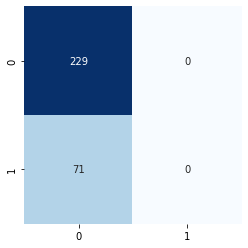

In [18]:
solv = 'newton-cg'
c = 10


learner = LogisticRegression(solver=solv, random_state=1, C=c)  
learner.fit(X_train,y_train ,sample_weight=train_fair.instance_weights)
predictions = learner.predict(X_test)

conclude = zip(predictions, y_test)

score = 0

correct_ans = []

for i in y_test:
  correct_ans.append(i)

lists = zip(predictions, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print("Model Accuracy", accuracy)

conf_mat = confusion_matrix(corrects, preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

test_pred = test.copy()
predictions.resize((len(predictions),1))
test_pred.labels = predictions

metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
#metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
#metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, acc))
print(metric_arrs)
print('\n')

**Task 2 Reweighted Fairness Model**

Model Accuracy 0.7633333333333333
C : 0.0001 | Activation: newton-cg | Accuracy: 0.6642991260487051
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}




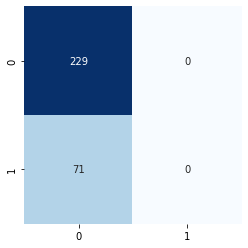

In [19]:
solv = 'newton-cg'
c = 0.0001


learner = LogisticRegression(solver=solv, random_state=1, C=c)  
learner.fit(X_train,y_train ,sample_weight=train_fair.instance_weights)
predictions = learner.predict(X_test)

conclude = zip(predictions, y_test)

score = 0

correct_ans = []

for i in y_test:
  correct_ans.append(i)

lists = zip(predictions, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print("Model Accuracy", accuracy)

conf_mat = confusion_matrix(corrects, preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

test_pred = test.copy()
predictions.resize((len(predictions),1))
test_pred.labels = predictions

metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
#metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
#metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, acc))
print(metric_arrs)
print('\n')

**Task 3 (EXTRA) Fairness Model 6**

Model Accuracy 0.6933333333333334
C : 0.001 | Activation: liblinear | Accuracy: 0.6642991260487051
{'stat_par_diff': -0.1432728517630948, 'eq_opp_diff': -0.12925170068027214, 'avg_odds_diff': -0.13558075750193976, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}




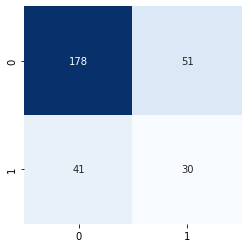

In [24]:
solv = 'liblinear'
c = 0.001


learner = LogisticRegression(solver=solv, random_state=1, C=c)  
learner.fit(X_train,y_train ,sample_weight=train_fair.instance_weights)
predictions = learner.predict(X_test)

conclude = zip(predictions, y_test)

score = 0

correct_ans = []

for i in y_test:
  correct_ans.append(i)

lists = zip(predictions, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print("Model Accuracy", accuracy)

conf_mat = confusion_matrix(corrects, preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

test_pred = test.copy()
predictions.resize((len(predictions),1))
test_pred.labels = predictions

metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
#metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
#metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, acc))
print(metric_arrs)
print('\n')

**Future work **

In [20]:
import tensorflow as tf


privileged_groups = [{'age': 1}]                                           #set the numbers for the privilage and unprivilage for the race
unprivileged_groups = [{'age': 0}]

sess = tf.compat.v1.Session()



tf.compat.v1.disable_eager_execution()

learner = LogisticRegression(solver='newton-cg', random_state=1, C=0.01)


plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

lis = np.arange(0.0, 1.0, 0.1)

accur = []



sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution()

debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess,
                          adversary_loss_weight = 0.1)

debiased_model = plain_model.fit(train)

preds = debiased_model.predict(test)

predictionsAAAAA = preds.labels

for i in y_test:
  correct_ans.append(i)

lists = zip(predictionsAAAAA, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0][0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0][0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print("Model Accuracy", accuracy)

accur.append(accuracy)
sess.close()

print(accur)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch 0; iter: 0; batch classifier loss: 0.648088
epoch 1; iter: 0; batch classifier loss: 0.623139
epoch 2; iter: 0; batch classifier loss: 0.627923
epoch 3; iter: 0; batch classifier loss: 0.601497
epoch 4; iter: 0; batch classifier loss: 0.566719
epoch 5; iter: 0; batch classifier loss: 0.591419
epoch 6; iter: 0; batch classifier loss: 0.604912
epoch 7; iter: 0; batch classifier loss: 0.621593
epoch 8; iter: 0; batch classifier loss: 0.624118
epoch 9; iter: 0; batch classifier loss: 0.581142
epoch 10; iter: 0; batch classifier loss: 0.596767
epoch 11; iter: 0; batch classifier loss: 0.539824
epoch 12; iter: 0; batch classifier loss: 0.590534
epoch 13; iter: 0; batch classifier loss: 0.579750
epoch 14; iter: 0; batch classifier loss: 0.546790
epoch 15; iter: 0; batch classifier loss: 0.576283
epoch 16; iter: 0; batch classifier loss: 0.613352
epoch 17; iter: 0; batch cla

Model Accuracy 0.7466666666666667
C : 0.0001 | Activation: newton-cg | Accuracy: 0.7466666666666667
{'stat_par_diff': 0.0, 'eq_opp_diff': 0.0, 'avg_odds_diff': 0.0, 'True_positive_rate': 1.0, 'False_positive_rate': 0.0}




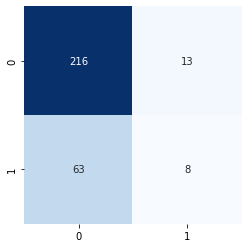

In [21]:
for i in y_test:
  correct_ans.append(i)

lists = zip(predictionsAAAAA, correct_ans)

preds = []
corrects = []

score = 0

for i in lists:
    if int(round(i[0][0])) == int(round(i[1])):
        score = score + 1
    else:
        pass
    
    var = round(i[0][0])
    preds.append(int(var))
    corrects.append(i[1])
  

accuracy = score/len(y_test)
print("Model Accuracy", accuracy)

conf_mat = confusion_matrix(corrects, preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

test_pred = test.copy() 
predictions.resize((len(predictionsAAAAA),1))
test_pred.labels = predictions

metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
#metric_arrs['between_group']=(metric.between_group_coefficient_of_variation())
#metric_arrs['generalized']=(metric.between_group_generalized_entropy_index())
metric_arrs['True_positive_rate']=(metric.generalized_true_positive_rate())
metric_arrs['False_positive_rate'] = (metric.num_generalized_false_positives())

print("C : {} | Activation: {} | Accuracy: {}".format(c, solv, accuracy))
print(metric_arrs)
print('\n')